# Sheet 7

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

plt.rc('font', family='monospace', size=14, serif='courier')
plt.rc('mathtext', fontset='stix')

# 3. Linear regions of MLPs

## (a)

#### (a).1

In [3]:
class Abs(nn.Module):
    """Absolute value activation function. You can experiment with this instead of ReLU."""
    def forward(self, x):
        return x.abs()
    
# define NN architecture.
class MLPShallow(nn.Module):
    def __init__(self,n,p,k):
        """
        Attributes:
        n : no. of inputs (dimensions)
        p : no. of neurons in hidden layer
        k : no. of nuerons in output layer
        """
        super(MLPShallow,self).__init__()
        # TODO: initialize Linear Layers and the activation as specified on the sheet
        self.hidden = nn.Linear(n, p, bias=True)    # hidden layer
        self.relu = nn.ReLU()                       # relu activation function
        self.abs = Abs()                            # absolute activation function
        self.output = nn.Linear(p, k, bias=True)    # output layer

        
    def forward(self, x):
        """
        Attributes:
        x : input matrix
        """       
        # TODO: pass the input x through the layers and return the output
        a = self.relu(self.hidden(x))   # input -> hidden       #a1 = ReLU(W_0 a_0 + b_0)      
        # a = self.abs(self.hidden(x))    # input -> hidden       #a1 = Abs(W_0 a_0 + b_0)
        y = self.output(a)              # hidden -> output      #y = W_1 a_1 + b_1
        
        return y

### (a).2 How many paramters does the model have?

Given equations,

$$
\begin{align*}
    a_0 &= \bold{x} \\
    a_{i+1} &= ReLU(\bold{W}_i \bold{a}_i + \bold{b}_i) \; for\; i \in {0,...,H-1} \\
    \bold{y} &= \bold{W}_H \bold{a}_H + \bold{b}_H
\end{align*}
$$

<!-- For $H=1$, the above equations become:

$$
\begin{align*}
    a_{1} &= ReLU(\bold{W}_0 \bold{x} + \bold{b}_0) \\
    \bold{y} &= \bold{W}_1 \bold{a}_1 + \bold{b}_1
\end{align*}
$$ -->

Now, when done dimension analysis on H=1, we can write (after taking transpose):

$$
\begin{alignat*}{2}
    \underset{m \times p}{\mathrm{a_{1}}} &=   ReLU(\;\underset{m \times n}{\bold{x}}\;\underset{n\times p}{\bold{W}_0} + \underset{1 \times p}{\bold{b}_0}\;) \\
    \underset{m \times k}{\mathrm{\bold{y}}} &=  \underset{m \times p}{\bold{a_1}}\;\underset{p \times k}{\bold{W}_1} + \underset{1 \times k}{\bold{b}_1}
\end{alignat*}
$$

where, 

- $m = $ no. of observations, 
- $n = $ size of input layer, 
- $p = $ size of hidden layer, \& 
- $k =$ size of output layer

So, for 2 dimensional input on 20 neuron hidden layer with single neuron ouput layer, we get, $n=2, \; p=20, \;k=1$,

Therefore,

- Parameters in Hidden layer, $P_{hidden} =  n \times p + 1 \times p = 40 + 20 = 60$
- Parameters in Output layer, $P_{output}: p \times k + 1 \times k = 20 + 1 = 21$

Hence,

**Total Parameters** in the model, $P_{hidden} + P_{output} = 81$



In [4]:
# the above answer can also be proved by calculating the no. of params in the model using `torchsummary.summary`
from torchsummary import summary 
_ = summary(MLPShallow(2,20,1))

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            60
├─ReLU: 1-2                              --
├─Abs: 1-3                               --
├─Linear: 1-4                            21
Total params: 81
Trainable params: 81
Non-trainable params: 0


- as this also shows, the total parameters are 81.

(b)

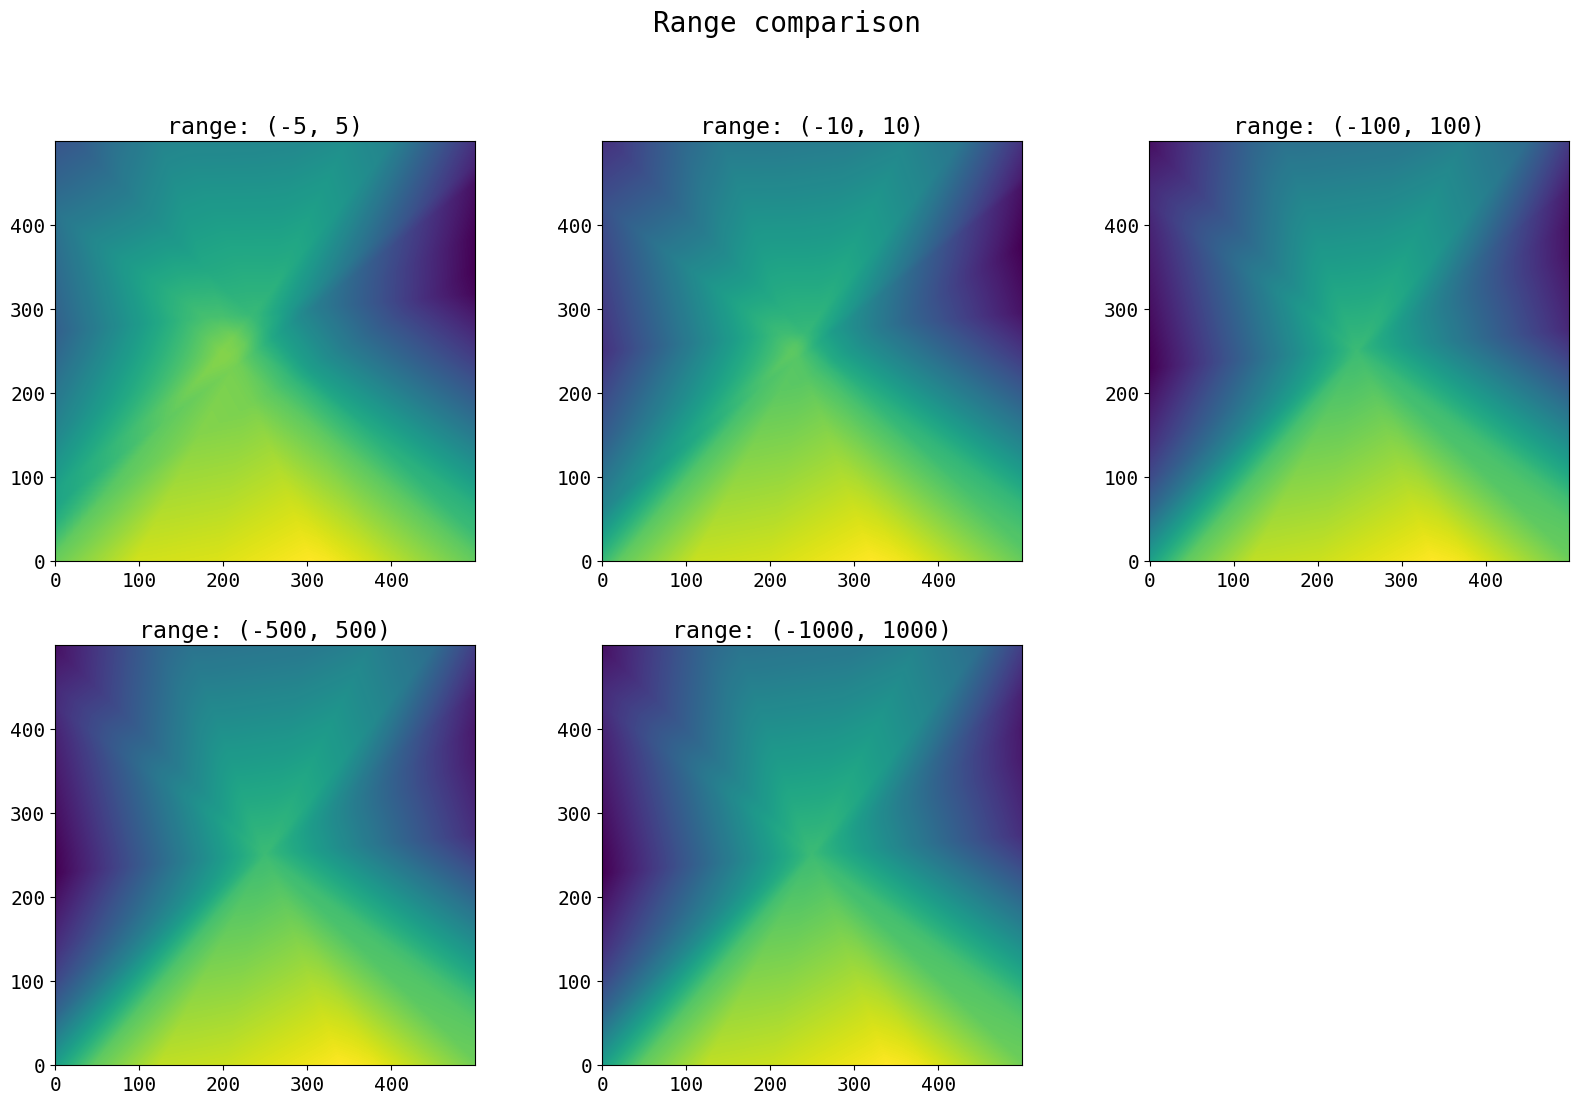

In [19]:
def visualize_model(model, res=500, bound=5):
    # TODO: implement a function that takes the model (the MLP), and builds a 
    #       grid of points in [-bound, bound] x [-bound, bound], passes them 
    #       through the model and returns the result in the shape of an image

    #grids of points
    x1 = np.linspace(-bound,bound,res)
    x2 = np.linspace(-bound,bound,res)
    x1v,x2v = np.meshgrid(x1,x2)                    

    # genrating the input torch.tensor 
    x = np.stack((x1v.ravel(),x2v.ravel()),axis=1)   
    x = torch.from_numpy(x).to(torch.float32)     

    # passing through model
    y = model(x)                                    
    
    return y.detach().numpy().reshape(res,res)      #reshaping the output vector into the shape of an image



# TODO: instantiate the model and make the visualizations as requested in the task
# NOTE: If you get a constant output, you got an unlucky initialization. Simply reinitialize the model.

model = MLPShallow(2,20,1)
bounds = [5,10,100,500,1000]
imgs = [visualize_model(model,res=500, bound=bound) for bound in bounds]

# plotting the model outputs for different ranges

plt.figure(figsize=(20,12))
plt.suptitle('Range comparison', fontsize=20, y=0.99)
plt.tight_layout()
#setting no. of rows and columns for subplot
ncols = 3
nrows = len(imgs) // ncols + (len(imgs) % ncols > 0) # calculating number of rows

for n,im in enumerate(imgs):
    #adding subplot iteratively
    ax = plt.subplot(nrows, ncols, n + 1)

    ax.imshow(im,origin='lower')
    ax.set_title(f'range: {-bounds[n],bounds[n]}')
    ax.set_aspect('equal')

- we can observe that as the range increases, the structure gets clearer and more refined. 
- after range: [-100,100], the structure doesn't improve by much factor as compared between range: [-10,10] to rangg: [-100,100]
- a possible reason for this could be that in the samll range, because of the fixed no. of points, the adjacent points are not sparse and therefore are quite close to each other, hence kind of blurred.
- as the range increaes, the sparsity of the points increases and they are able to map much larger spaces, hence much more clearer strcuture. 

(c)

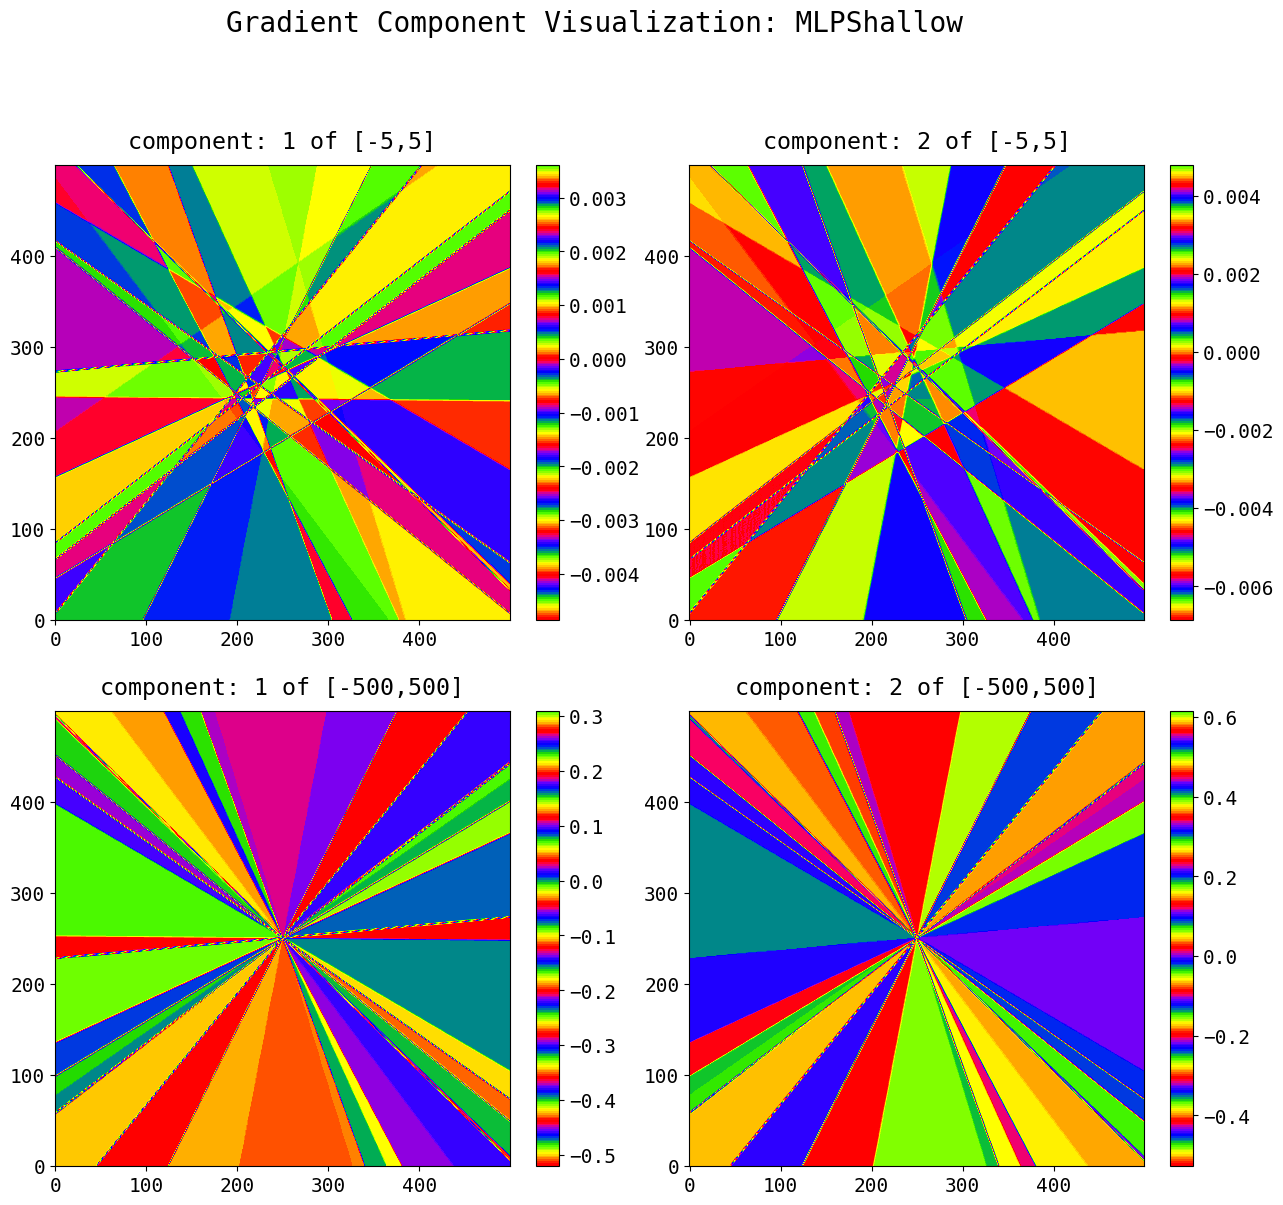

In [82]:
# TODO: compute the spatial gradient of the network outputs (as an image) from (b)
#       using np.gradient, and visualize using matplotlib's prism colormap

c1, c2 = np.gradient(imgs[0]) #for range (-5,5)
c3, c4 = np.gradient(imgs[3]) #for range (-500,500)

# plotting the model outputs for different ranges

fig = plt.figure(figsize=(15,13))
plt.suptitle('Gradient Component Visualization: MLPShallow', fontsize=20, y=1)
plt.tight_layout()

#setting no. of rows and columns for subplot
ncols = 2
nrows = 2

c = [c1,c2,c3,c4]
label = ['component: 1 of [-5,5]','component: 2 of [-5,5]','component: 1 of [-500,500]','component: 2 of [-500,500]']

for n,(ci,li) in enumerate(zip(c,label)):
    #adding subplot iteratively
    ax = plt.subplot(nrows, ncols, n + 1)

    cim = ax.imshow(ci,origin='lower',cmap='prism')
    ax.set_title(li, y=1.02)
    ax.set_aspect('equal')
    fig.colorbar(cim, ax=ax, fraction=0.046)


### Inference:

- `np.gradient` gives us the gradient of the input array with respect to each dimension with the same shape
- the pattern in the component images of respective ranges is almost similar with a few changes but the level changes which is represented by different colors
- for the range [-5,5], pattern is almost chaotic but for range [-500,500], the structure is quite clear
- also, the colorbar of component 2 of both the levels are quite spread out which indicates the the levels are spread out too as compared to the component 1

(d)

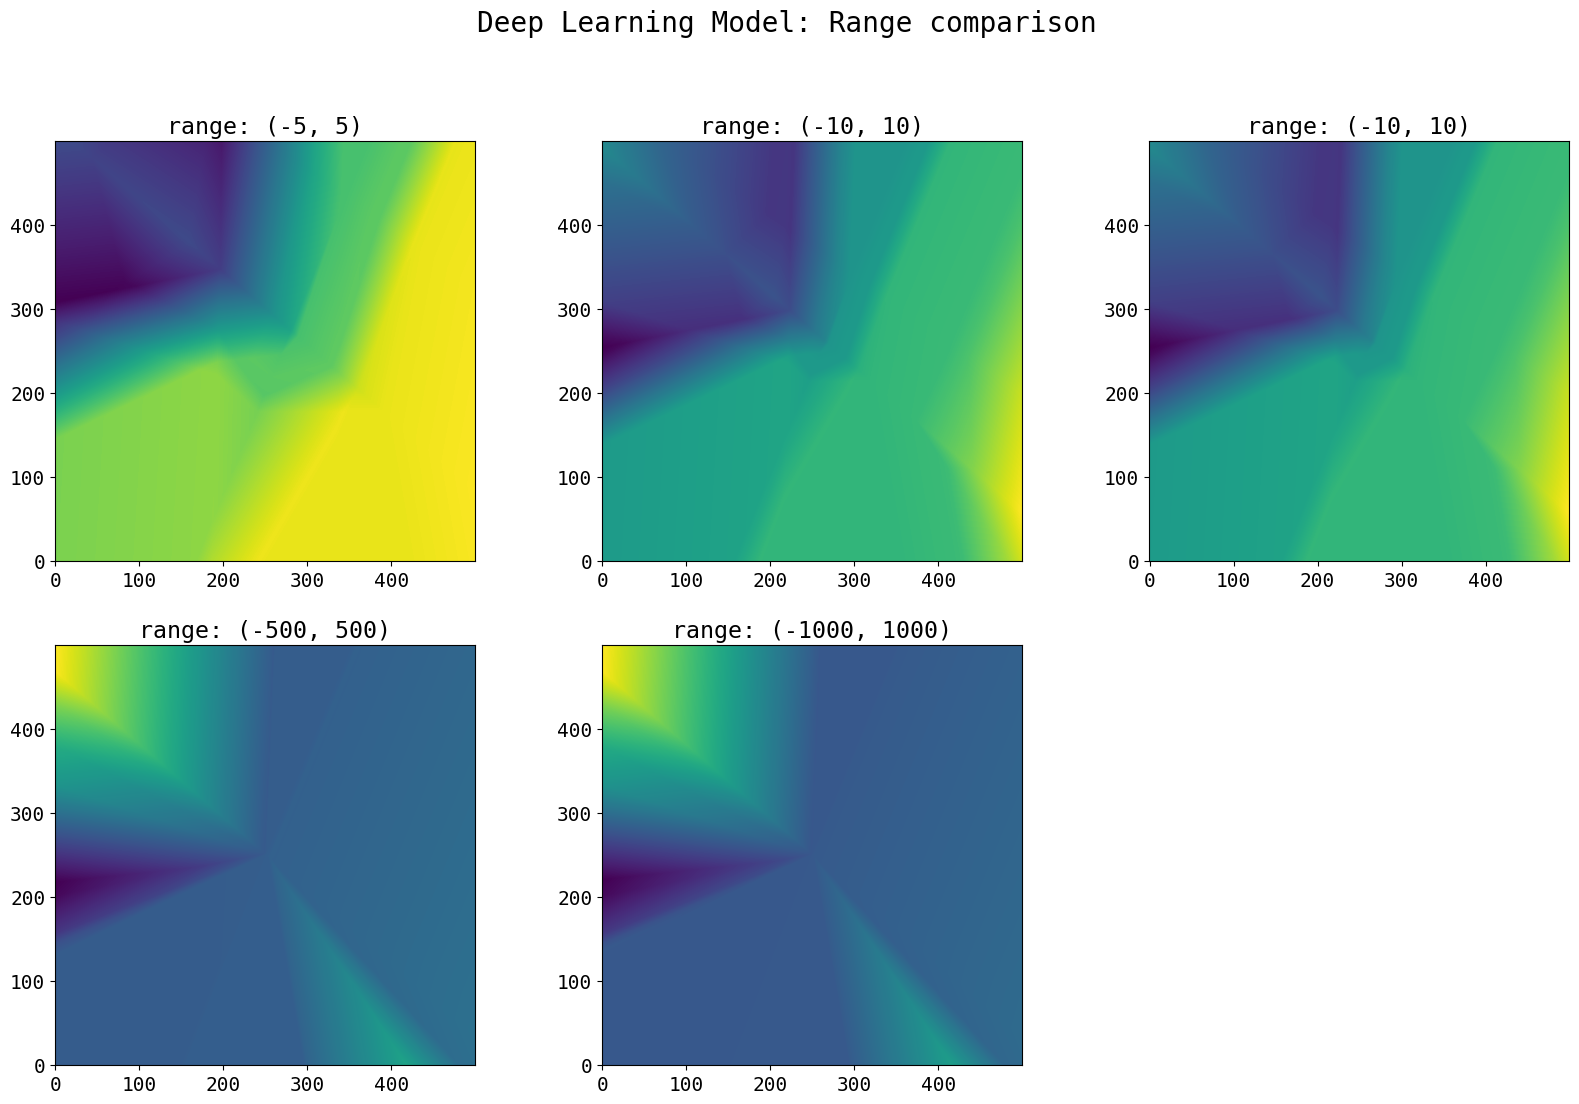

In [63]:
# define NN architecture.
class MLPDeep(nn.Module):
    def __init__(self,n=2,p=5,k=1):
        """
        Attributes:
        n : no. of inputs (dimensions)
        p : no. of neurons in hidden layers
        k : no. of nuerons in output layer
        """
        super(MLPDeep,self).__init__()
        # TODO: initialize Linear Layers and the activation as specified on the sheet  
        self.multi_hidden = nn.Sequential(
                            nn.Linear(n, p),        # hidden layer 1
                            nn.ReLU(),                # relu
                            nn.Linear(p, p),        # hidden layer 2
                            nn.ReLU(),
                            nn.Linear(p, p),        # hidden layer 3
                            nn.ReLU(),
                            nn.Linear(p, p),        # hidden layer 4
                            nn.ReLU(),                                                                                 
                            nn.Linear(p,k))          # output layer  

    
    def forward(self, x):
        # TODO: pass the input x through the layers and return the output
        """
        Attributes:
        x : input matrix
        """       
        # TODO: pass the input x through the layers and return the outpu 
        y = self.multi_hidden(x)  
        return y

# TODO: repeat the visualizations from above
model_deep = MLPDeep(2,5,1)
bounds = [5,10,10,500,1000]
img = [visualize_model(model_deep,res=500, bound=bound) for bound in bounds]

# plotting the model outputs for different ranges

plt.figure(figsize=(20,12))
plt.suptitle('Deep Learning Model: Range comparison', fontsize=20, y=0.99)
plt.tight_layout()
#setting no. of rows and columns for subplot
ncols = 3
nrows = len(img) // ncols + (len(img) % ncols > 0) # calculating number of rows

for n,im in enumerate(img):
    #adding subplot iteratively
    ax = plt.subplot(nrows, ncols, n + 1)

    ax.imshow(im,origin='lower')
    ax.set_title(f'range: {-bounds[n],bounds[n]}')
    ax.set_aspect('equal')

### Inference: 
- The results are actually impressive! 
- Structures are quite clear even from the beginning, although their shape changes as we increase the range (we are not sure why)
- Ones with the lower range are more rough or would say that it has more distinctions in the structures whereas the range of [-1000,1000] looks quite different and has more smoother surface.

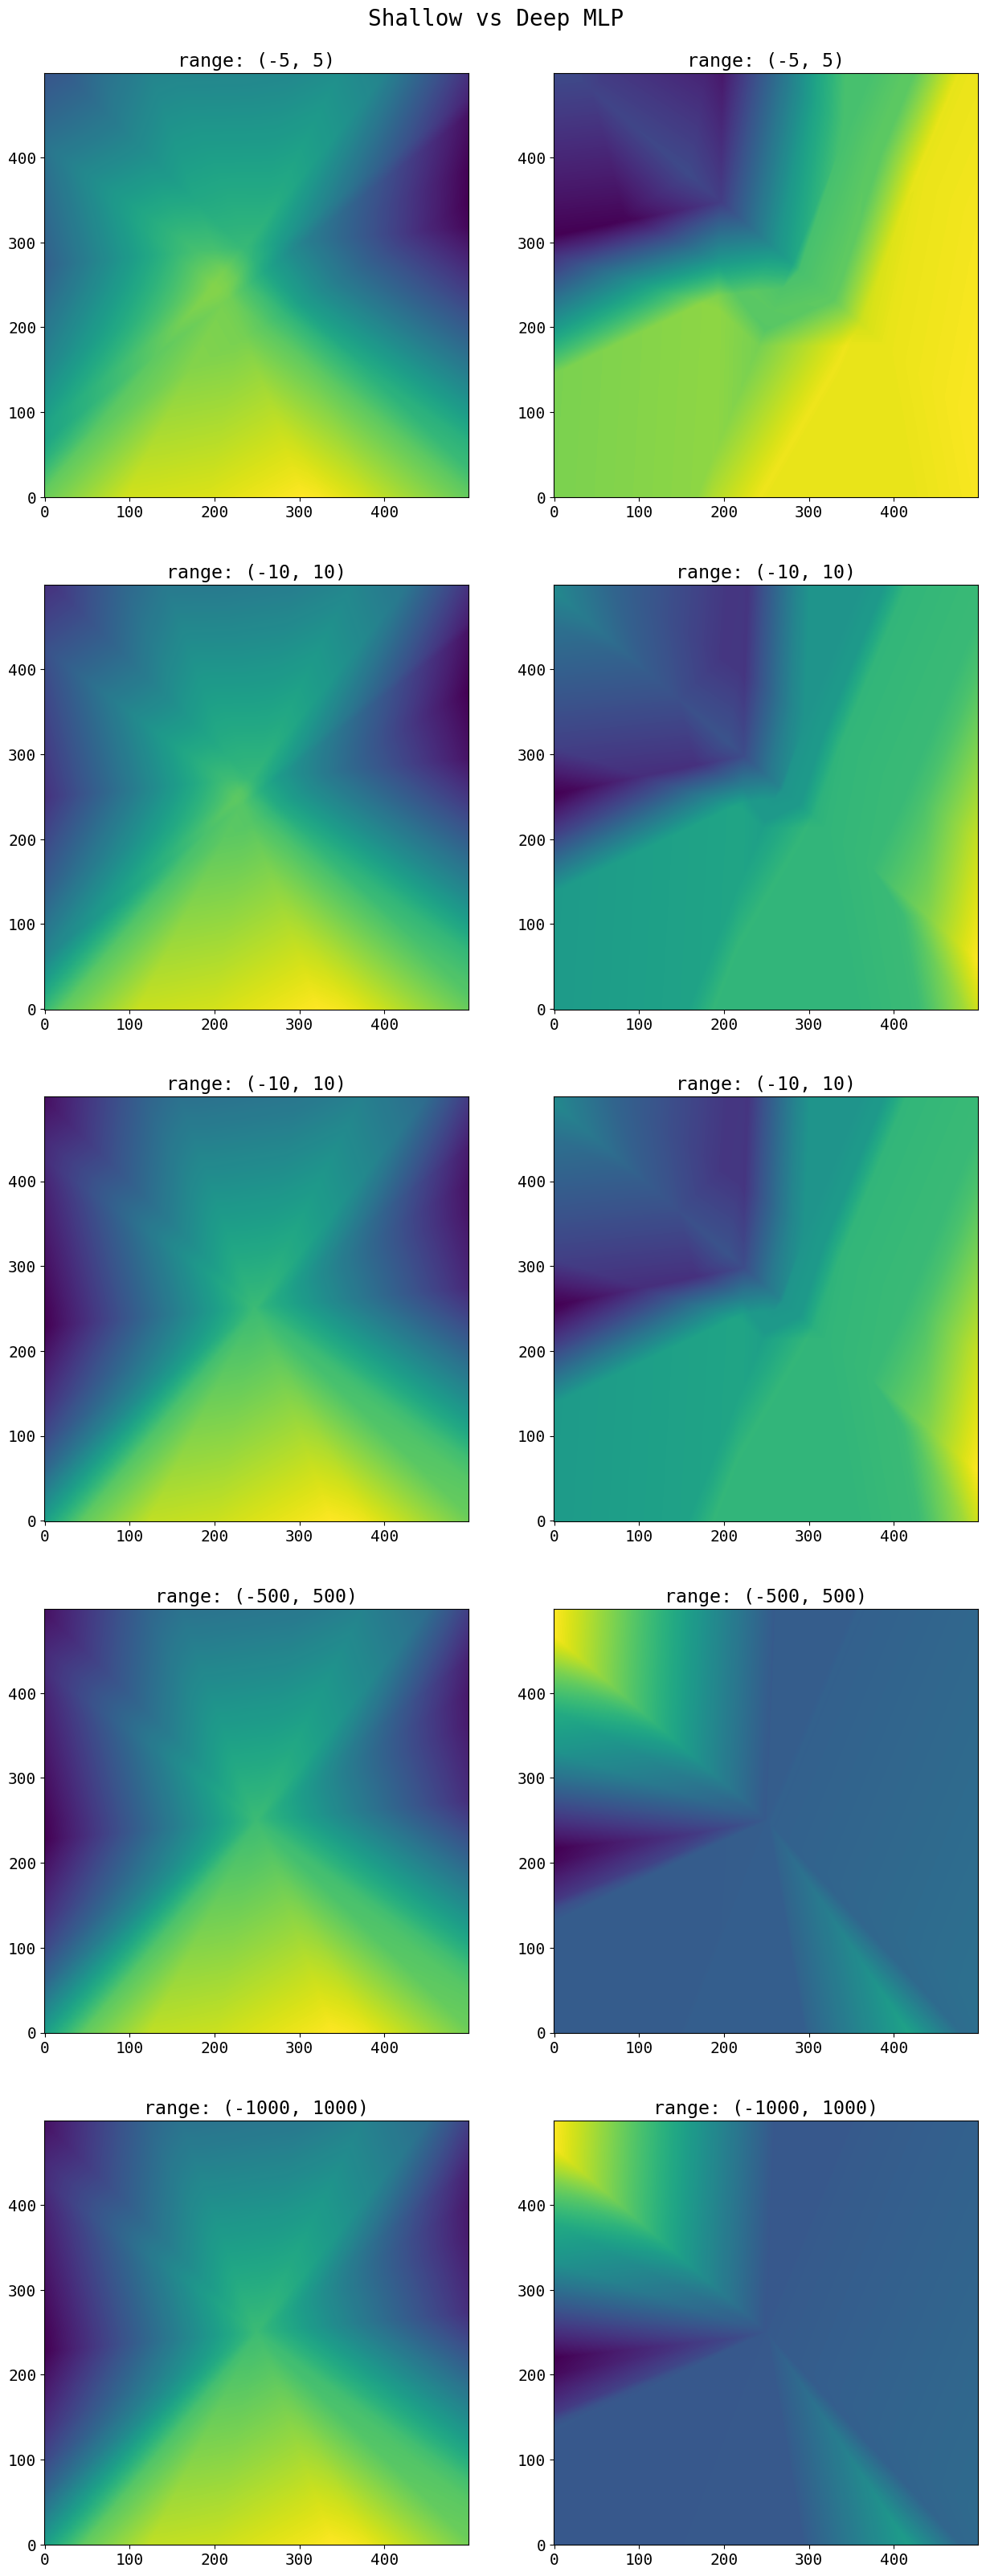

In [81]:
#combining the img arrays alternatively for comparison plotting
img_com = [x for y in zip(imgs,img) for x in y]
bnd_com = [x for y in zip(bounds,bounds) for x in y]

plt.figure(figsize=(15,40))
plt.suptitle('Shallow vs Deep MLP', fontsize=20, y=0.9)
plt.tight_layout()
#setting no. of rows and columns for subplot
ncols = 2
nrows = len(img_com) // ncols + (len(img_com) % ncols > 0) # calculating number of rows

for n, im_com in enumerate(img_com):
    #adding subplot iteratively
    ax = plt.subplot(nrows, ncols, n + 1)

    ax.imshow(im_com,origin='lower')
    ax.set_title(f'range: {-bnd_com[n],bnd_com[n]}')
    ax.set_aspect('equal')

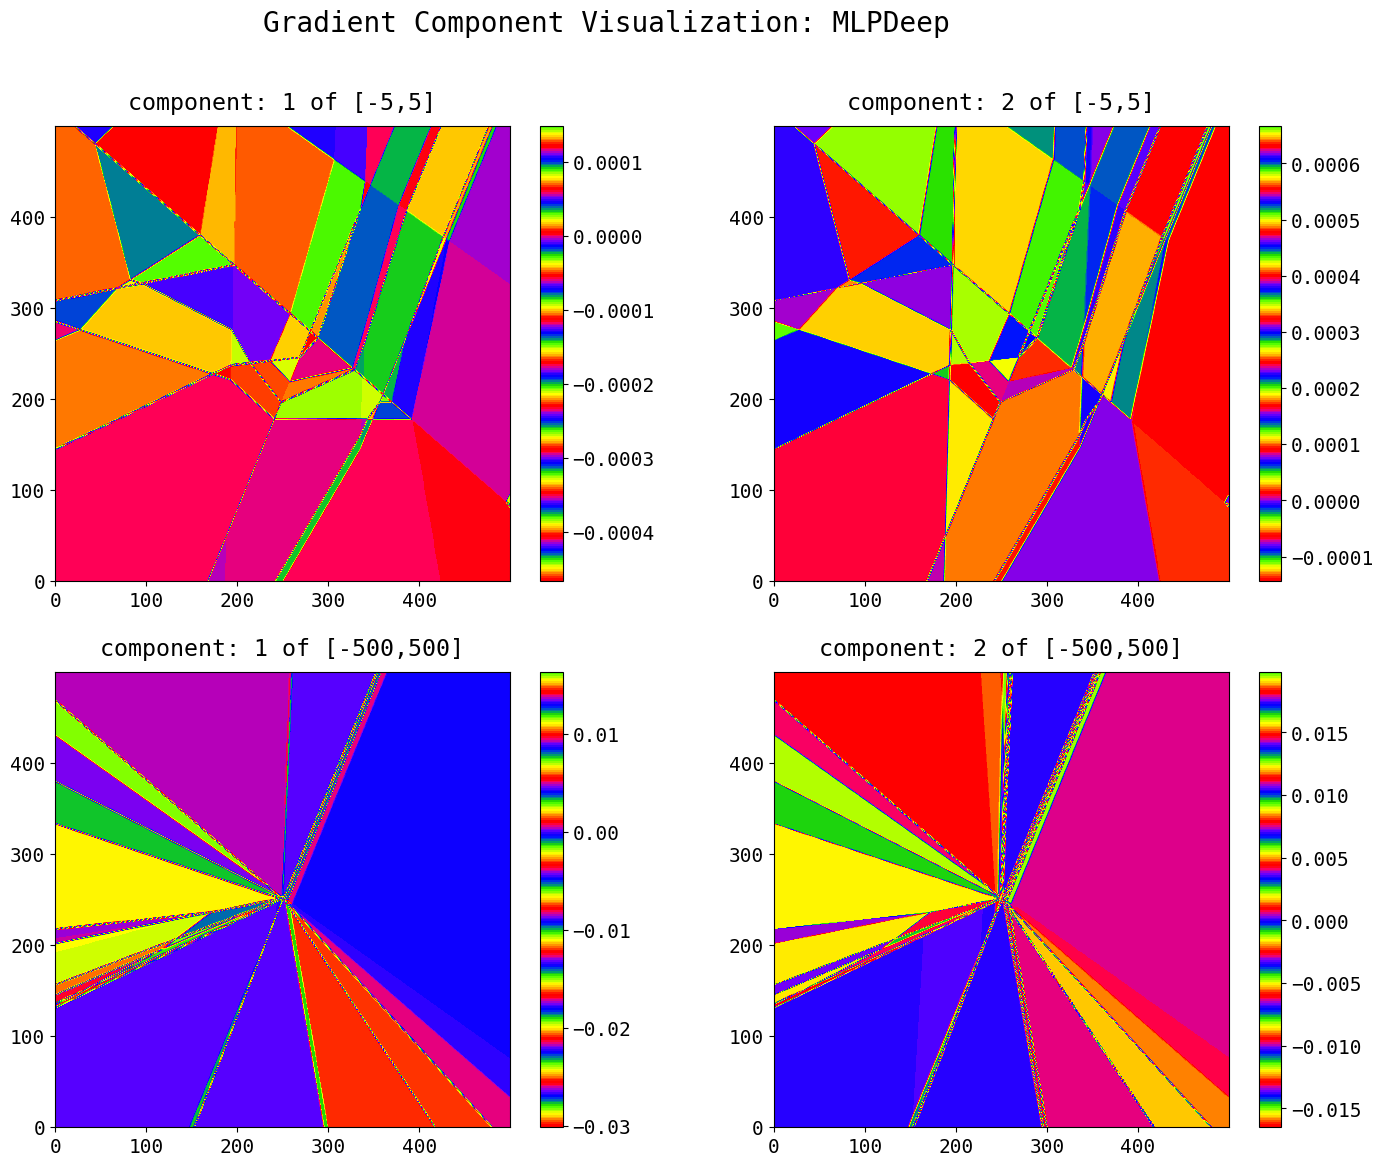

In [85]:
# TODO: compute the spatial gradient of the network outputs (as an image) from (b)
#       using np.gradient, and visualize using matplotlib's prism colormap

c1, c2 = np.gradient(img[0]) #for range (-5,5)
c3, c4 = np.gradient(img[3]) #for range (-500,500)

# plotting the model outputs for different ranges

fig = plt.figure(figsize=(17,13))
plt.suptitle('Gradient Component Visualization: MLPDeep', fontsize=20, y=0.97)
plt.tight_layout()

#setting no. of rows and columns for subplot
ncols = 2
nrows = 2

c = [c1,c2,c3,c4]
label = ['component: 1 of [-5,5]','component: 2 of [-5,5]','component: 1 of [-500,500]','component: 2 of [-500,500]']

for n,(ci,li) in enumerate(zip(c,label)):
    #adding subplot iteratively
    ax = plt.subplot(nrows, ncols, n + 1)

    cim = ax.imshow(ci,origin='lower',cmap='prism')
    ax.set_title(li, y=1.02)
    ax.set_aspect('equal')
    fig.colorbar(cim, ax=ax, fraction=0.046)

### Inference:
- here also, the pattern is similiar but has some little differences
- although color map ranges doesn't follow the usual behaviour now